In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import roc_auc_score,roc_curve,f1_score,auc,confusion_matrix,log_loss

from bs4 import BeautifulSoup
import re

In [2]:
df=pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df=df.drop(['keyword','location','id'],axis=1)

In [4]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [5]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [6]:
from tqdm import tqdm
# from nltk.corpus import stopwords
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(df.text.values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████| 7613/7613 [00:03<00:00, 2296.46it/s]


In [7]:
c=pd.DataFrame(preprocessed_reviews,columns=['text'])
c

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked ishelter place notified office...
3,people receive wildfires evacuation orders cal...
4,got sent photo ruby alaska smoke wildfires pou...
...,...
7608,two giant cranes holding bridge collapse nearb...
7609,aria ahrary thetawniest control wild fires cal...
7610,volcano hawaii
7611,police investigating e bike collided car littl...


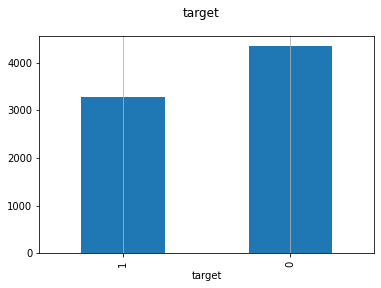

In [8]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
df["target"].reset_index().groupby("target").count().sort_values(by= "index").plot(kind="bar", legend=False,
        ax=ax).grid(axis='x')
plt.show() 

In [9]:
x=c
y=df.target

In [10]:
x.head()

,text
0,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada
2,residents asked ishelter place notified office...
3,people receive wildfires evacuation orders cal...
4,got sent photo ruby alaska smoke wildfires pou...


In [11]:
x.shape,y.shape

((7613, 1), (7613,))

In [12]:
x_train,x_test,y_train, y_test= train_test_split(x,y,test_size=0.2, stratify=y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((6090, 1), (1523, 1), (6090,), (1523,))

In [13]:
count_vect_bow= CountVectorizer()
text_vec_bow=count_vect_bow.fit(x_train.text)

x_train_text_bow= count_vect_bow.transform(x_train.text)
x_test_text_bow= count_vect_bow.transform(x_test.text)

x_train_text_bow.shape,x_test_text_bow.shape

((6090, 13648), (1523, 13648))

for alpha = 5
Log Loss : 0.5723042492094489
for alpha = 11
Log Loss : 0.5814852035248892
for alpha = 15
Log Loss : 0.5844447733579284
for alpha = 21
Log Loss : 0.5802057532695456
for alpha = 31
Log Loss : 0.5707610118383412
for alpha = 41
Log Loss : 0.5776053472986171
for alpha = 51
Log Loss : 0.5879909368682608
for alpha = 99
Log Loss : 0.5690657515993082
for alpha = 120
Log Loss : 0.5686540463166782
for alpha = 151
Log Loss : 0.5831041999610548


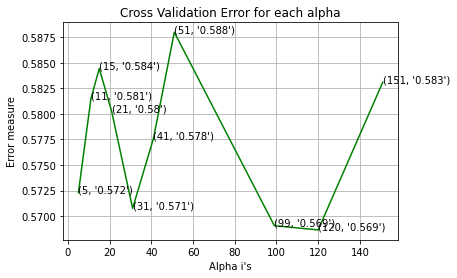

For values of best alpha =  120 The train log loss is: 0.5267
For values of best alpha =  120 The cross validation log loss is: 0.5687


In [14]:
#KNN
alpha = [5, 11, 15, 21, 31, 41, 51, 99, 120,151]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train_text_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_bow, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_bow)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_knn = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha_knn])
clf.fit(x_train_text_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_bow, y_train)

y_train_pred=sig_clf.predict(x_train_text_bow)
y_test_pred= sig_clf.predict(x_test_text_bow)

best_alpha_knn=alpha[best_alpha_knn]
predict_y_train = sig_clf.predict_proba(x_train_text_bow)
train_log_loss_knn=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-3),4)
print('For values of best alpha = ',best_alpha_knn , "The train log loss is:",train_log_loss_knn)

predict_y_test = sig_clf.predict_proba(x_test_text_bow)
test_log_loss_knn=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-3),4)
print('For values of best alpha = ', best_alpha_knn, "The cross validation log loss is:",test_log_loss_knn)


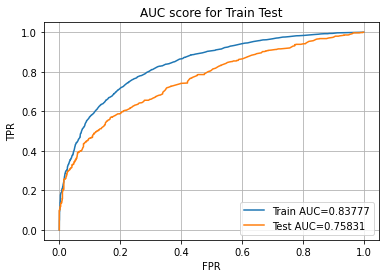

In [15]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_knn=np.round(auc(train_fpr,train_tpr),5)
test_auc_knn=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_knn))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_knn))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [16]:
def find_best_threshold(tr_threshold, fpr, tpr):
# picking the threshold which gives the least FPR value
    t = tr_threshold[np.argmax(tpr*(1-fpr))]
    print('Threshold:',np.round(t,3),'\nThe maximum value of tpr*(1-fpr)',max(tpr*(1-fpr)))
    return t

def predict_for_best_t(prob, threshold):
    pred=[]
    for i in prob: # for each probabilty value on test data
        if i>=threshold: # if probabilty value greater than or equal to threshold then it is 1
            pred.append(1)
        else: # if probabilty value less than threshold then it is 0
            pred.append(0)
    return pred


In [17]:
# finding the best Threshold value on BOW
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))

TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_KNN= np.round((2*Precision*Recall)/(Recall+Precision),3)
print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_KNN))

Threshold: 0.39 
The maximum value of tpr*(1-fpr) 0.5777370293968175
TPR: 76.49%
FPR: 69.17%
Precision: 47.25%
Recall: 76.49%
F1 Score: 58.415% 


for alpha = 1e-05
Log Loss : 0.5240129921614958
for alpha = 0.0001
Log Loss : 0.5222993079539375
for alpha = 0.001
Log Loss : 0.5174308843410852
for alpha = 0.1
Log Loss : 0.48613292814046866
for alpha = 1
Log Loss : 0.462335634150887
for alpha = 10
Log Loss : 0.4581407208479264
for alpha = 100
Log Loss : 0.49819399173444584
for alpha = 1000
Log Loss : 0.5434702324170325


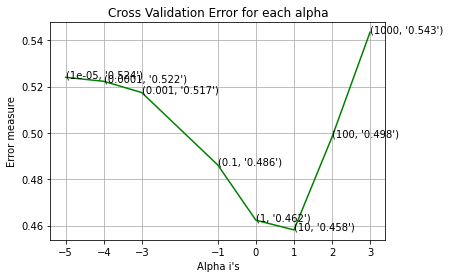

For values of best alpha =  10 The train log loss is: 0.3771
For values of best alpha =  10 The cross validation log loss is: 0.4581


In [18]:
#NB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(x_train_text_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_bow, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_bow)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_NB = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha_NB])
clf.fit(x_train_text_bow,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_bow,y_train)

y_train_pred=sig_clf.predict(x_train_text_bow)
y_test_pred= sig_clf.predict(x_test_text_bow)

best_alpha_NB=alpha[best_alpha_NB]
predict_y_train = sig_clf.predict_proba(x_train_text_bow)
train_logloss_nb=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_NB, "The train log loss is:",train_logloss_nb)

predict_y_test = sig_clf.predict_proba(x_test_text_bow)
test_logloss_nb=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ',best_alpha_NB , "The cross validation log loss is:",test_logloss_nb)


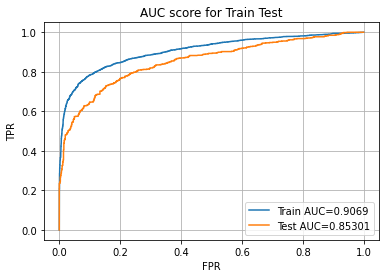

In [19]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_nb=np.round(auc(train_fpr,train_tpr),5)
test_auc_nb=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_nb))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_nb))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [20]:
# finding the best Threshold value on BOW
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))

TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_NB_BOW= np.round((2*Precision*Recall)/(Recall+Precision),3)
print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_NB_BOW))

Threshold: 0.447 
The maximum value of tpr*(1-fpr) 0.7054835704574434
TPR: 79.11%
FPR: 79.55%
Precision: 70.64%
Recall: 79.11%
F1 Score: 74.635% 


In [21]:
from sklearn.linear_model import SGDClassifier

for alpha = 1e-06
Log Loss : 0.48686354018989475
for alpha = 1e-05
Log Loss : 0.46227398472682174
for alpha = 0.0001
Log Loss : 0.45045963671878925
for alpha = 0.001
Log Loss : 0.44243273935856736
for alpha = 0.01
Log Loss : 0.470750781230904
for alpha = 0.1
Log Loss : 0.5097676832123887
for alpha = 1
Log Loss : 0.5207551587874609
for alpha = 10
Log Loss : 0.5221220166383826
for alpha = 100
Log Loss : 0.522154597295282


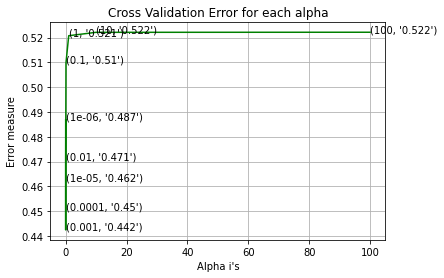

For values of best alpha =  0.001 The train log loss is: 0.3066
For values of best alpha =  0.001 The cross validation log loss is: 0.4424


In [22]:
#LR
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_text_bow,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_bow,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_bow)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_lr = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_lr], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_text_bow,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_bow,y_train)

y_train_pred=sig_clf.predict(x_train_text_bow)
y_test_pred= sig_clf.predict(x_test_text_bow)

best_alpha_lr=alpha[best_alpha_lr]
predict_y_train = sig_clf.predict_proba(x_train_text_bow)
train_logloss_lr=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ',best_alpha_lr , "The train log loss is:",train_logloss_lr)

predict_y_test = sig_clf.predict_proba(x_test_text_bow)
test_logloss_lr=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_lr , "The cross validation log loss is:",test_logloss_lr)

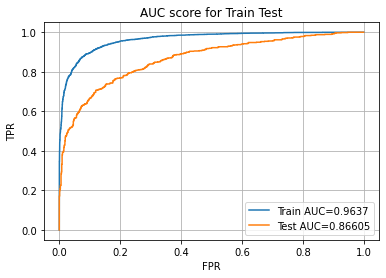

In [23]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_lr=np.round(auc(train_fpr,train_tpr),5)
test_auc_lr=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_lr))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_lr))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [24]:
# finding the best Threshold value on BOW
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))


TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_LR_BOW= np.round((2*Precision*Recall)/(Recall+Precision),3)
print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_LR_BOW))

Threshold: 0.414 
The maximum value of tpr*(1-fpr) 0.8114235907526604
TPR: 79.12%
FPR: 80.19%
Precision: 71.87%
Recall: 79.12%
F1 Score: 75.321% 


for C = 1e-05
Log Loss : 0.48143763599161365
for C = 0.0001
Log Loss : 0.4722281704572746
for C = 0.001
Log Loss : 0.45183697531900224
for C = 0.01
Log Loss : 0.45761035352494234
for C = 0.1
Log Loss : 0.5215938442630583
for C = 1
Log Loss : 0.5219769244505063
for C = 10
Log Loss : 0.5219769212296289
for C = 100
Log Loss : 0.5219769243026708


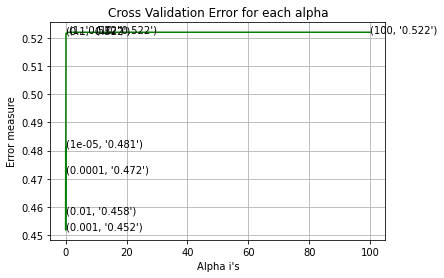

For values of best alpha =  0.001 The train log loss is: 0.275
For values of best alpha =  0.001 The test log loss is: 0.4518


In [25]:
#SVM
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(x_train_text_bow,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_bow,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_bow)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_svm = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_svm], penalty='l2', loss='hinge', random_state=42)
clf.fit(x_train_text_bow,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_bow,y_train)

y_train_pred=sig_clf.predict(x_train_text_bow)
y_test_pred= sig_clf.predict(x_test_text_bow)

best_alpha_svm=alpha[best_alpha_svm]
predict_y_train = sig_clf.predict_proba(x_train_text_bow)
train_logloss_svm=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_svm , "The train log loss is:",train_logloss_svm)

predict_y_test = sig_clf.predict_proba(x_test_text_bow)
test_logloss_svm=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_svm , "The test log loss is:",test_logloss_svm)

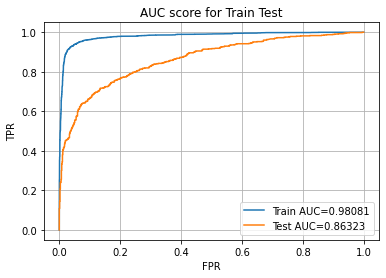

In [26]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_svm=np.round(auc(train_fpr,train_tpr),5)
test_auc_svm=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_svm))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_svm))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [27]:
# finding the best Threshold value on BOW
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))


TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_svm_bow= np.round((2*Precision*Recall)/(Recall+Precision),3)

print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_svm_bow))

Threshold: 0.427 
The maximum value of tpr*(1-fpr) 0.8927065618157476
TPR: 79.9%
FPR: 80.24%
Precision: 71.71%
Recall: 79.9%
F1 Score: 75.584% 


100%|████████████████████████████████████████████| 6/6 [02:29<00:00, 24.88s/it]


log_loss for c =  10 is 0.4719034515545197
log_loss for c =  50 is 0.4598912277208438
log_loss for c =  100 is 0.4605690728308995
log_loss for c =  120 is 0.4600461237912109
log_loss for c =  150 is 0.4612450058747674
log_loss for c =  180 is 0.4613721937932602


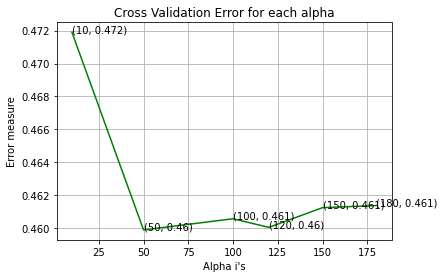

For values of best alpha =  50 The train log loss is: 0.2424
For values of best alpha =  50 The test log loss is: 0.4599


In [51]:
# random Forest
alpha=[10,50,100,120,150,180]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier

for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(x_train_text_bow,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(x_train_text_bow,y_train)
    predict_y = sig_clf.predict_proba(x_test_text_bow)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha_rf = np.argmin(cv_log_error_array)
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha_rf],random_state=42,n_jobs=-1)
r_cfl.fit(x_train_text_bow,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train_text_bow,y_train)

y_train_pred=sig_clf.predict(x_train_text_bow)
y_test_pred= sig_clf.predict(x_test_text_bow)

best_alpha_rf=alpha[best_alpha_rf]
predict_y_train = sig_clf.predict_proba(x_train_text_bow)
train_logloss_rf=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_rf , "The train log loss is:",train_logloss_rf)

predict_y_test = sig_clf.predict_proba(x_test_text_bow)
test_logloss_rf=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_rf , "The test log loss is:",test_logloss_rf)

In [52]:
# best_alpha_rf=alpha[best_alpha_rf]
predict_y_train = sig_clf.predict_proba(x_train_text_bow)
train_logloss_rf=np.round(log_loss(y_train, predict_y_train),4)
print('For values of best alpha = ', best_alpha_rf , "The train log loss is:",train_logloss_rf)

predict_y_test = sig_clf.predict_proba(x_test_text_bow)
test_logloss_rf=np.round(log_loss(y_test, predict_y_test),4)
print('For values of best alpha = ', best_alpha_rf , "The test log loss is:",test_logloss_rf)

For values of best alpha =  50 The train log loss is: 0.2424
For values of best alpha =  50 The test log loss is: 0.4599


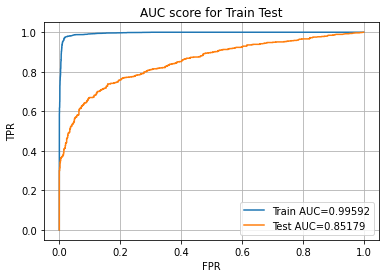

In [53]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_rf=np.round(auc(train_fpr,train_tpr),5)
test_auc_rf=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_rf))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_rf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [54]:
# finding the best Threshold value on TFIDF_W2V
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))


TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_rf_bow= np.round((2*Precision*Recall)/(Recall+Precision),3)

print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_rf_bow))

Threshold: 0.484 
The maximum value of tpr*(1-fpr) 0.9565364824844004
TPR: 78.85%
FPR: 79.83%
Precision: 71.25%
Recall: 78.85%
F1 Score: 74.858% 


In [55]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Model', 'Best Hyper Parameter', 'Train Log Loss', 'Test Log Loss', 'Accuracy','F1-SCORE']
table.add_row(['KNN', best_alpha_knn, train_log_loss_knn, test_log_loss_knn, test_auc_knn, F1_Score_KNN])
table.add_row(['Naive Bayes', best_alpha_NB, train_logloss_nb, test_logloss_nb, test_auc_nb, F1_Score_NB_BOW])
table.add_row(['Logistic Regression', best_alpha_lr, train_logloss_lr, test_logloss_lr, test_auc_lr, F1_Score_LR_BOW])
table.add_row(['SVM', best_alpha_svm, train_logloss_svm, test_logloss_svm, test_auc_svm, F1_Score_svm_bow])
table.add_row(['Random Forest', best_alpha_rf, train_logloss_rf, test_logloss_rf, test_auc_rf, F1_Score_rf_bow])
print(table)

+---------------------+----------------------+----------------+---------------+----------+----------+
|        Model        | Best Hyper Parameter | Train Log Loss | Test Log Loss | Accuracy | F1-SCORE |
+---------------------+----------------------+----------------+---------------+----------+----------+
|         KNN         |         120          |     0.5267     |     0.5687    | 0.75831  |  58.415  |
|     Naive Bayes     |          10          |     0.3771     |     0.4581    | 0.85301  |  74.635  |
| Logistic Regression |        0.001         |     0.3066     |     0.4424    | 0.86605  |  75.321  |
|         SVM         |        0.001         |     0.275      |     0.4518    | 0.86323  |  75.584  |
|    Random Forest    |          50          |     0.2424     |     0.4599    | 0.85179  |  74.858  |
+---------------------+----------------------+----------------+---------------+----------+----------+


# TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect_tfidf= TfidfVectorizer()
text_vec_tfidf=count_vect_tfidf.fit(x_train.text)

x_train_text_tfidf= count_vect_tfidf.transform(x_train.text)
x_test_text_tfidf= count_vect_tfidf.transform(x_test.text)

x_train_text_tfidf.shape,x_test_text_tfidf.shape

((6090, 13648), (1523, 13648))

for alpha = 5
Log Loss : 0.4910344924486147
for alpha = 11
Log Loss : 0.47848733874561017
for alpha = 15
Log Loss : 0.47815232697157667
for alpha = 21
Log Loss : 0.47540226686327497
for alpha = 31
Log Loss : 0.4730103258834718
for alpha = 41
Log Loss : 0.47538463772833894
for alpha = 51
Log Loss : 0.47685328806634447
for alpha = 99
Log Loss : 0.48697460329314446
for alpha = 120
Log Loss : 0.4936594031228189
for alpha = 151
Log Loss : 0.5080777083313534


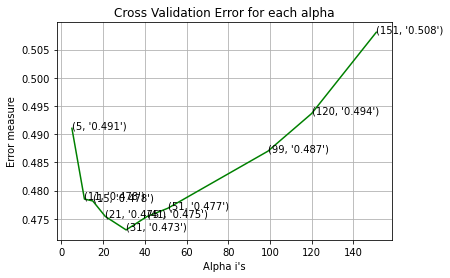

For values of best alpha =  31 The train log loss is: 0.4549
For values of best alpha =  31 The cross validation log loss is: 0.473


In [34]:
#KNN
alpha = [5, 11, 15, 21, 31, 41, 51, 99, 120,151]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train_text_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_tfidf)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_knn_tfidf = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha_knn_tfidf])
clf.fit(x_train_text_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_tfidf, y_train)

y_train_pred=sig_clf.predict(x_train_text_tfidf)
y_test_pred= sig_clf.predict(x_test_text_tfidf)

best_alpha_knn_tfidf=alpha[best_alpha_knn_tfidf]
predict_y_train = sig_clf.predict_proba(x_train_text_tfidf)
train_logloss_knn_tfidf=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-3),4)
print('For values of best alpha = ',best_alpha_knn_tfidf , "The train log loss is:",train_logloss_knn_tfidf)

predict_y_test = sig_clf.predict_proba(x_test_text_tfidf)
test_logloss_knn_tfidf=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-3),4)
print('For values of best alpha = ', best_alpha_knn_tfidf, "The cross validation log loss is:",test_logloss_knn_tfidf)


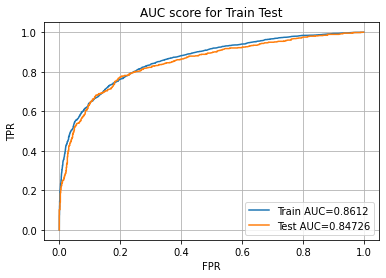

In [35]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_knn_tfidf=np.round(auc(train_fpr,train_tpr),5)
test_auc_knn_tfidf=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_knn_tfidf))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_knn_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [36]:
# finding the best Threshold value on TFIDF_W2V
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_tfidf=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))

TPR=np.round(cm_tfidf[1][1]/(cm_tfidf[0][1]+cm_tfidf[1][1])*100,2)
FPR=np.round(cm_tfidf[0][0]/(cm_tfidf[0][0]+cm_tfidf[1][0])*100,2)
Precision= np.round(cm_tfidf[1][1]/(cm_tfidf[1][0]+cm_tfidf[1][1])*100,2)
Recall = TPR
F1_Score_KNN_tfidf= np.round((2*Precision*Recall)/(Recall+Precision),3)
print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_KNN_tfidf))

Threshold: 0.464 
The maximum value of tpr*(1-fpr) 0.6111322664793014
TPR: 75.97%
FPR: 79.49%
Precision: 71.56%
Recall: 75.97%
F1 Score: 73.699% 


for alpha = 1e-05
Log Loss : 0.524719507072407
for alpha = 0.0001
Log Loss : 0.5192624048814938
for alpha = 0.001
Log Loss : 0.508924387609991
for alpha = 0.1
Log Loss : 0.46080548657443005
for alpha = 1
Log Loss : 0.443218078203163
for alpha = 10
Log Loss : 0.45870328908588665
for alpha = 100
Log Loss : 0.48128169807126936
for alpha = 1000
Log Loss : 0.4886112693690783


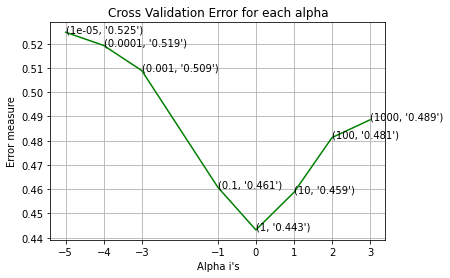

For values of best alpha =  1 The train log loss is: 0.3035
For values of best alpha =  1 The cross validation log loss is: 0.4432


In [37]:
#NB
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(x_train_text_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_tfidf, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_tfidf)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_NB_tfidf = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha_NB_tfidf])
clf.fit(x_train_text_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_tfidf,y_train)

y_train_pred=sig_clf.predict(x_train_text_tfidf)
y_test_pred= sig_clf.predict(x_test_text_tfidf)

best_alpha_NB_tfidf=alpha[best_alpha_NB_tfidf]
predict_y_train = sig_clf.predict_proba(x_train_text_tfidf)
train_logloss_nb_tfidf=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_NB_tfidf, "The train log loss is:",train_logloss_nb_tfidf)

predict_y_test = sig_clf.predict_proba(x_test_text_tfidf)
test_logloss_nb_tfidf=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ',best_alpha_NB_tfidf , "The cross validation log loss is:",test_logloss_nb_tfidf)


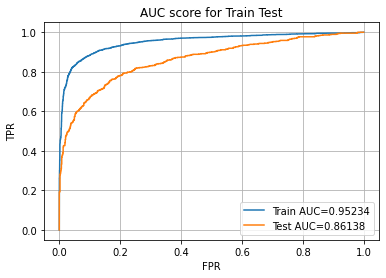

In [38]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_nb_tfidf=np.round(auc(train_fpr,train_tpr),5)
test_auc_nb_tfidf=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_nb_tfidf))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_nb_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [39]:
# finding the best Threshold value on TFIDF_W2V
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_tfidf=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))

TPR=np.round(cm_tfidf[1][1]/(cm_tfidf[0][1]+cm_tfidf[1][1])*100,2)
FPR=np.round(cm_tfidf[0][0]/(cm_tfidf[0][0]+cm_tfidf[1][0])*100,2)
Precision= np.round(cm_tfidf[1][1]/(cm_tfidf[1][0]+cm_tfidf[1][1])*100,2)
Recall = TPR
F1_Score_NB_tfidf= np.round((2*Precision*Recall)/(Recall+Precision),3)
print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_NB_tfidf))

Threshold: 0.382 
The maximum value of tpr*(1-fpr) 0.7987046973315959
TPR: 80.82%
FPR: 79.27%
Precision: 69.57%
Recall: 80.82%
F1 Score: 74.774% 


for alpha = 1e-06
Log Loss : 0.4664135659052579
for alpha = 1e-05
Log Loss : 0.4582483192043329
for alpha = 0.0001
Log Loss : 0.447513025223917
for alpha = 0.001
Log Loss : 0.4602013676081322
for alpha = 0.01
Log Loss : 0.4731225876970513
for alpha = 0.1
Log Loss : 0.4757466954525377
for alpha = 1
Log Loss : 0.47624434270778215
for alpha = 10
Log Loss : 0.4763021070189535
for alpha = 100
Log Loss : 0.47627859350374036


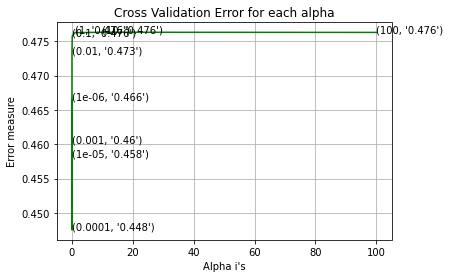

For values of best alpha =  0.0001 The train log loss is: 0.2771
For values of best alpha =  0.0001 The cross validation log loss is: 0.4475


In [40]:
#LR
from sklearn.linear_model import SGDClassifier
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train_text_tfidf,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_tfidf,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_tfidf)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_lr_tfidf = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_lr_tfidf], penalty='l2', loss='log', random_state=42)
clf.fit(x_train_text_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_tfidf,y_train)

y_train_pred=sig_clf.predict(x_train_text_tfidf)
y_test_pred= sig_clf.predict(x_test_text_tfidf)

best_alpha_lr_tfidf=alpha[best_alpha_lr_tfidf]
predict_y_train = sig_clf.predict_proba(x_train_text_tfidf)
train_logloss_lr_tfidf=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ',best_alpha_lr_tfidf , "The train log loss is:",train_logloss_lr_tfidf)

predict_y_test = sig_clf.predict_proba(x_test_text_tfidf)
test_logloss_lr_tfidf=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_lr_tfidf , "The cross validation log loss is:",test_logloss_lr_tfidf)

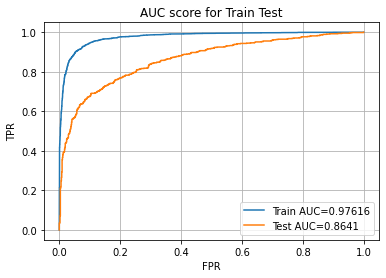

In [41]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_lr_tfidf=np.round(auc(train_fpr,train_tpr),5)
test_auc_lr_tfidf=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_lr_tfidf))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_lr_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [42]:
# finding the best Threshold value on TFIDF_W2V
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))


TPR=np.round(cm[1][1]/(cm[0][1]+cm[1][1])*100,2)
FPR=np.round(cm[0][0]/(cm[0][0]+cm[1][0])*100,2)
Precision= np.round(cm[1][1]/(cm[1][0]+cm[1][1])*100,2)
Recall = TPR
F1_Score_LR_tfidf= np.round((2*Precision*Recall)/(Recall+Precision),3)
print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_LR_tfidf))

Threshold: 0.408 
The maximum value of tpr*(1-fpr) 0.8560147547965686
TPR: 77.42%
FPR: 80.73%
Precision: 73.39%
Recall: 77.42%
F1 Score: 75.351% 


for C = 1e-05
Log Loss : 0.47888003235555965
for C = 0.0001
Log Loss : 0.46143862741547886
for C = 0.001
Log Loss : 0.45572975943352834
for C = 0.01
Log Loss : 0.4762304125678312
for C = 0.1
Log Loss : 0.47622667758653064
for C = 1
Log Loss : 0.4762266889172921
for C = 10
Log Loss : 0.4762266962927773
for C = 100
Log Loss : 0.4762266769591889


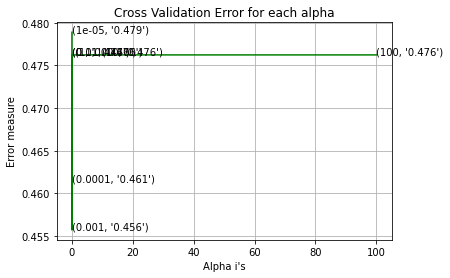

For values of best alpha =  0.001 The train log loss is: 0.3419
For values of best alpha =  0.001 The test log loss is: 0.4557


In [43]:
#SVM
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(x_train_text_tfidf,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_text_tfidf,y_train)
    sig_clf_probs = sig_clf.predict_proba(x_test_text_tfidf)
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_test, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_svm_tfidf = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha_svm_tfidf], penalty='l2', loss='hinge', random_state=42)
clf.fit(x_train_text_tfidf,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_text_tfidf,y_train)

y_train_pred=sig_clf.predict(x_train_text_tfidf)
y_test_pred= sig_clf.predict(x_test_text_tfidf)

best_alpha_svm_tfidf=alpha[best_alpha_svm_tfidf]
predict_y_train = sig_clf.predict_proba(x_train_text_tfidf)
train_logloss_svm_tfidf=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_svm_tfidf , "The train log loss is:",train_logloss_svm_tfidf)

predict_y_test = sig_clf.predict_proba(x_test_text_tfidf)
test_logloss_svm_tfidf=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_svm_tfidf , "The test log loss is:",test_logloss_svm_tfidf)

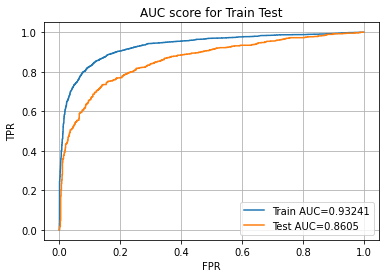

In [44]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_svm_tfidf=np.round(auc(train_fpr,train_tpr),5)
test_auc_svm_tfidf=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_svm_tfidf))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_svm_tfidf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [45]:
# finding the best Threshold value on TFIDF_W2V
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))


TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_svm_tfidf= np.round((2*Precision*Recall)/(Recall+Precision),3)

print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_svm_tfidf))

Threshold: 0.395 
The maximum value of tpr*(1-fpr) 0.7513554258458256
TPR: 78.39%
FPR: 81.4%
Precision: 74.31%
Recall: 78.39%
F1 Score: 76.295% 


100%|████████████████████████████████████████████| 6/6 [02:32<00:00, 25.37s/it]


log_loss for c =  10 is 0.47916557251233177
log_loss for c =  50 is 0.4642534436303852
log_loss for c =  100 is 0.46509191462076876
log_loss for c =  120 is 0.4653379857510414
log_loss for c =  150 is 0.4653361859985841
log_loss for c =  180 is 0.4652712566857396


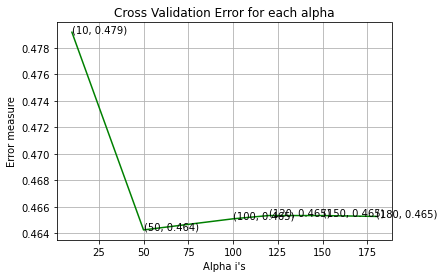

For values of best alpha =  50 The train log loss is: 0.2444
For values of best alpha =  50 The test log loss is: 0.4643


In [46]:
# random Forest
alpha=[10,50,100,120,150,180]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier

for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(x_train_text_tfidf,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(x_train_text_tfidf,y_train)
    predict_y = sig_clf.predict_proba(x_test_text_tfidf)
    cv_log_error_array.append(log_loss(y_test, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha_rf = np.argmin(cv_log_error_array)
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha_rf],random_state=42,n_jobs=-1)
r_cfl.fit(x_train_text_tfidf,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(x_train_text_tfidf,y_train)

y_train_pred=sig_clf.predict(x_train_text_tfidf)
y_test_pred= sig_clf.predict(x_test_text_tfidf)

best_alpha_rf=alpha[best_alpha_rf]
predict_y_train = sig_clf.predict_proba(x_train_text_tfidf)
train_logloss_rf=np.round(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_rf , "The train log loss is:",train_logloss_rf)

predict_y_test = sig_clf.predict_proba(x_test_text_tfidf)
test_logloss_rf=np.round(log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15),4)
print('For values of best alpha = ', best_alpha_rf , "The test log loss is:",test_logloss_rf)

In [47]:
# best_alpha_rf=alpha[best_alpha_rf]
predict_y_train = sig_clf.predict_proba(x_train_text_tfidf)
train_logloss_rf=np.round(log_loss(y_train, predict_y_train),4)
print('For values of best alpha = ', best_alpha_rf , "The train log loss is:",train_logloss_rf)

predict_y_test = sig_clf.predict_proba(x_test_text_tfidf)
test_logloss_rf=np.round(log_loss(y_test, predict_y_test),4)
print('For values of best alpha = ', best_alpha_rf , "The test log loss is:",test_logloss_rf)

For values of best alpha =  50 The train log loss is: 0.2444
For values of best alpha =  50 The test log loss is: 0.4643


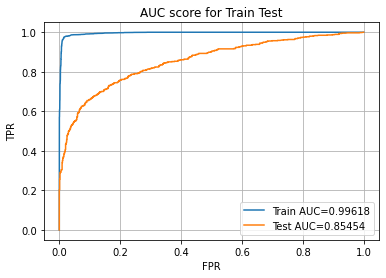

In [48]:
# finding FPR, TPR, Threshold value based on ROC curve on Train data
train_fpr, train_tpr, tr_threshold = roc_curve(y_train,predict_y_train[:,1])

# finding FPR, TPR, Threshold value based on ROC curve on Test data
test_fpr, test_tpr, te_threshold = roc_curve(y_test, predict_y_test[:,1])
# plotting the AUC curve on both Train and Test Data
train_auc_rf=np.round(auc(train_fpr,train_tpr),5)
test_auc_rf=np.round(auc(test_fpr,test_tpr),5)
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(train_auc_rf))
plt.plot(test_fpr, test_tpr ,label='Test AUC='+str(test_auc_rf))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC score for Train Test')
plt.grid()
plt.show()

In [49]:
# finding the best Threshold value on TFIDF_W2V
best_threshold=find_best_threshold(tr_threshold,train_fpr,train_tpr)
# performing Confusion matrix on Actual test and predicted probability of Test based on best threshold
cm_bow=confusion_matrix(y_test,predict_for_best_t(y_test_pred,best_threshold))


TPR=np.round(cm_bow[1][1]/(cm_bow[0][1]+cm_bow[1][1])*100,2)
FPR=np.round(cm_bow[0][0]/(cm_bow[0][0]+cm_bow[1][0])*100,2)
Precision= np.round(cm_bow[1][1]/(cm_bow[1][0]+cm_bow[1][1])*100,2)
Recall = TPR
F1_Score_rf_bow= np.round((2*Precision*Recall)/(Recall+Precision),3)

print("TPR: {}%\nFPR: {}%\nPrecision: {}%\nRecall: {}%\nF1 Score: {}% ".format(TPR,FPR,Precision,Recall,F1_Score_rf_bow))

Threshold: 0.495 
The maximum value of tpr*(1-fpr) 0.9603762459922007
TPR: 76.03%
FPR: 80.65%
Precision: 73.7%
Recall: 76.03%
F1 Score: 74.847% 


In [50]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Model', 'Best Hyper Parameter', 'Train Log Loss', 'Test Log Loss', 'Accuracy','F1-SCORE']
table.add_row(['KNN', best_alpha_knn_tfidf, train_logloss_knn_tfidf, test_logloss_knn_tfidf, test_auc_knn_tfidf, F1_Score_KNN_tfidf])
table.add_row(['Naive Bayes', best_alpha_NB_tfidf, train_logloss_nb_tfidf, test_logloss_nb_tfidf, test_auc_nb_tfidf, F1_Score_NB_tfidf])
table.add_row(['Logistic Regression', best_alpha_lr_tfidf, train_logloss_lr_tfidf, test_logloss_lr, test_auc_lr_tfidf, F1_Score_LR_tfidf])
table.add_row(['SVM', best_alpha_svm_tfidf, train_logloss_svm_tfidf, test_logloss_svm_tfidf, test_auc_svm_tfidf, F1_Score_svm_tfidf])
table.add_row(['Random Forest', best_alpha_rf, train_logloss_rf, test_logloss_rf, test_auc_rf, F1_Score_rf_bow])
print(table)

+---------------------+----------------------+----------------+---------------+----------+----------+
|        Model        | Best Hyper Parameter | Train Log Loss | Test Log Loss | Accuracy | F1-SCORE |
+---------------------+----------------------+----------------+---------------+----------+----------+
|         KNN         |          31          |     0.4549     |     0.473     | 0.84726  |  73.699  |
|     Naive Bayes     |          1           |     0.3035     |     0.4432    | 0.86138  |  74.774  |
| Logistic Regression |        0.0001        |     0.2771     |     0.4424    |  0.8641  |  75.351  |
|         SVM         |        0.001         |     0.3419     |     0.4557    |  0.8605  |  76.295  |
|    Random Forest    |          50          |     0.2444     |     0.4643    | 0.85454  |  74.847  |
+---------------------+----------------------+----------------+---------------+----------+----------+
